# DenseNet12


## Data Preparation and Splitting for Training and Testing Sets

In [14]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),  # Resize while maintaining aspect ratio
    transforms.CenterCrop(224),  # Crop to 224x224 for model compatibility
    transforms.RandomRotation(5),  # Reduce rotation to avoid excessive distortion    
    transforms.RandomHorizontalFlip(),  # Use if flipping is realistic for your dataset
    transforms.ToTensor(),  # Convert to Tensor
    # transforms.Normalize(mean=[83.69595705397771 / 255.0], std=[56.3543633764882 / 255.0])  # Use dataset-specific mean and std
])

# Dataset path and categories
dataset_dir = '/home/maryam.alshehyari/Documents/training/Data/Dataset_BUSI_with_GT'
categories = ['normal', 'benign', 'malignant']

# Load images and labels
images = []
labels = []

for category in categories:
    path = os.path.join(dataset_dir, category)
    class_num = categories.index(category)
    for img_name in os.listdir(path):
        if '_mask' not in img_name:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(img)  # Apply transformations
            images.append(img)
            labels.append(class_num)


# Convert lists to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_tensor, labels_tensor, test_size=0.2, random_state=random_seed, stratify=labels_tensor)



# Create datasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Save the training and testing data into separate files for consistency
train_data_path = "/home/maryam.alshehyari/Documents/training/train_data_withT.pt"
test_data_path = "/home/maryam.alshehyari/Documents/training/test_data_withT.pt"
torch.save(train_dataset, train_data_path)
torch.save(test_dataset, test_data_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train data saved at: {train_data_path}")
print(f"Test data saved at: {test_data_path}")
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")



Train data saved at: /home/maryam.alshehyari/Documents/training/train_data_withT.pt
Test data saved at: /home/maryam.alshehyari/Documents/training/test_data_withT.pt
Training samples: 624, Testing samples: 156


## Training and Validation of DenseNet12

In [15]:
# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffling for validation

# Load the pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)

# Modify the classifier for 3 classes
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 100  # Set the number of epochs
best_val = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track the loss for this epoch

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as model

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)

    # Calculate average training loss
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    best_val = 0.0  # Initialize the best validation accuracy
    avg_val_loss = validation_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    if accuracy > best_val:
        best_val = accuracy
        torch.save(model.state_dict(), "/home/maryam.alshehyari/Documents/training/densenet121_ultrasound.pth")

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the final model (optional)
# torch.save(model.state_dict(), "/home/maryam.alshehyari/Documents/training/densenet121_ultrasound.pth")
print(f"Best Validation Accuracy: {best_val:.2f}%")


/home/maryam.alshehyari/Documents/training/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maryam.alshehyari/Documents/training/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Training Loss: 0.7836
Validation Loss: 0.8242, Accuracy: 62.82%
Epoch 2/100, Training Loss: 0.5608
Validation Loss: 0.7314, Accuracy: 69.87%
Epoch 3/100, Training Loss: 0.3541
Validation Loss: 0.7350, Accuracy: 71.79%
Epoch 4/100, Training Loss: 0.3193
Validation Loss: 0.5050, Accuracy: 80.13%
Epoch 5/100, Training Loss: 0.2704
Validation Loss: 0.5719, Accuracy: 76.92%
Epoch 6/100, Training Loss: 0.2051
Validation Loss: 0.4991, Accuracy: 80.77%
Epoch 7/100, Training Loss: 0.1085
Validation Loss: 0.7377, Accuracy: 71.15%
Epoch 8/100, Training Loss: 0.1220
Validation Loss: 0.7631, Accuracy: 78.85%
Epoch 9/100, Training Loss: 0.0982
Validation Loss: 0.6102, Accuracy: 76.92%
Epoch 10/100, Training Loss: 0.0876
Validation Loss: 1.0788, Accuracy: 71.79%
Epoch 11/100, Training Loss: 0.1378
Validation Loss: 0.9658, Accuracy: 71.15%
Epoch 12/100, Training Loss: 0.3325
Validation Loss: 3.4918, Accuracy: 60.90%
Epoch 13/100, Training Loss: 0.2299
Validation Loss: 0.5459, Accuracy: 80

## Visualizing Training and Validation Metrics for Model Performance


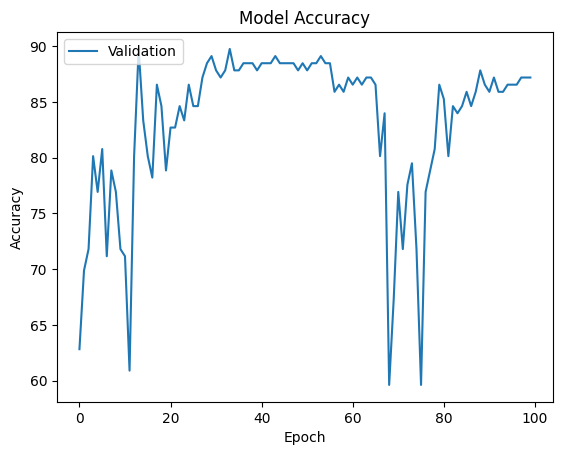

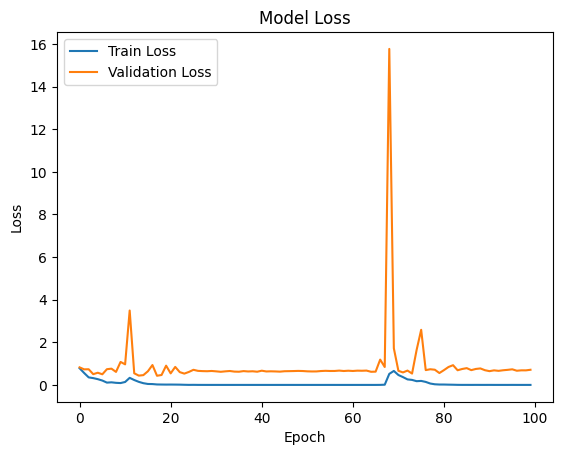

: 

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(val_accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
